# CartPole Experiment

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

In [2]:
# What do I want to do here?

# Cartpole is an environment provided by OpenAI gym.
# This is one of the basic RL envs - has been described as the "Hello World" of RL 
# The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
# angular velocity in that order (numbers output from env.reset())
# env.step(action = 0 or 1) gives us observation, reward, done, info, in that order
# reward = +1 for every additional step, including termination step
# More info can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

# I want use a DQN algorithm to train an agent to complete this environment successfully
# I plan on experimenting with different:
# a) neural net architectures
# b) learning rates 
# c) explore / exploit values

In [3]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cartpole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.05, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each training step.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)) #USED TO BE 2.5e-4
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer='adam')
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 10000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If random float is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cartpole environment with the agent.
        
        Arguments:
            env: Cartpole environment object
        
        Returns:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            done (bool): Whether or not episode has terminated
            action (int): 1 or 0, corresponding to whether the cart was pushed left or right
            info (dict): Empty dictionary
        """
        
        action = self.find_action(self.state)
        new_state, reward, done, info = env.step(action)[:4]
        old_state = self.state
        self.state = new_state
        return old_state, action, reward, new_state, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate future reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        model = Sequential(
            [
                Dense(512, activation='relu', input_shape=(4,)),
                Dense(256, activation='relu'),
                Dense(128, activation='relu'),
                Dense(64, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target q = reward + gamma * target q of next state
        future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose=False), axis=1)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        target_vals = self.memory[:, 5] + self.gamma * future_reward
        
        q_vals = self.q_function.predict(self.memory[:, :4], verbose=False)
        
        current_actions = self.memory[:, 4]
        col1 = ((q_vals[:, 0] * current_actions) + ((1 - current_actions) * target_vals)).reshape(q_vals.shape[0], 1)
        col2 = ((q_vals[:, 1] * (1 - current_actions)) + (current_actions * target_vals)).reshape(q_vals.shape[0], 1)
        final_target = np.concatenate((col1, col2), axis=1)
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], final_target, shuffle=True, batch_size=64, verbose=False)
        
        # Update target-q to be tau * target q weights + (1 - tau) * q weights
        new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
        self.target_q.set_weights(new_weights) 
        
        # Update epsilon
#         self.epsilon *= self.epsilon_decay
#         self.epsilon = max(self.epsilon, self.epsilon_min)
        
        
    def go(self, env, num_rounds=100, train_freq=5):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cartpole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            train_freq (int): Train the agent after every train_freq rounds.
            
        Returns:
            None
        """
        
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                old_state, action, reward, new_state, done = self.take_step(env)
                
                # Add data to current iteration memory
                if self.memory.any():
                    curr_data = np.append(np.append(old_state, (action, reward, done)), new_state).reshape(1, 11)
                    self.memory = np.concatenate((self.memory, curr_data), axis=0)
                else: 
                    self.memory = (np.append(np.append(old_state, (action, reward, done)), new_state)).reshape(1, 11)
                
                if len(self.memory) > self.max_memory:
                    idx = np.random.randint(0, self.max_memory, size=self.max_memory) 
                    self.memory = self.memory[idx, :]
                    
                if len(self.memory) > 64:
                    self.train()
                
                if done:
                    complete = True
                    
                length += 1

                
             # Update epsilon
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)
            
            length_lst.append(length)
            
            if i % 10 == 0:
                print("Episode {} last 10 reward avg: {}, epsilon: {}".format(i, np.mean(length_lst[-10:]), self.epsilon))
                               
        return length_lst


In [4]:
def rolling_average(lengths, window):
    avgs = []
    for i in range(len(lengths)):
        if i < window:
            avgs.append(0)
        else:
            avgs.append(np.mean(lengths[i - window: i]))
    return avgs

In [5]:
agent = DQNAgent()

In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [7]:
lengths = agent.go(env, num_rounds=250)

  1%|▋                                                                                            | 2/250 [00:00<00:13, 18.96it/s]

Episode 0 last 10 reward avg: 19.0, epsilon: 0.891


  4%|████                                                                                        | 11/250 [00:06<03:29,  1.14it/s]

Episode 10 last 10 reward avg: 14.6, epsilon: 0.8058044288328449


  8%|███████▋                                                                                    | 21/250 [00:19<05:11,  1.36s/it]

Episode 20 last 10 reward avg: 15.9, epsilon: 0.7287550813991327


 12%|███████████▍                                                                                | 31/250 [00:33<06:21,  1.74s/it]

Episode 30 last 10 reward avg: 17.3, epsilon: 0.6590730326889578


 16%|███████████████                                                                             | 41/250 [01:07<18:14,  5.24s/it]

Episode 40 last 10 reward avg: 33.4, epsilon: 0.5960538368855853


 20%|██████████████████▊                                                                         | 51/250 [02:28<35:06, 10.58s/it]

Episode 50 last 10 reward avg: 62.8, epsilon: 0.5390604058195451


 24%|██████████████████████▍                                                                     | 61/250 [03:34<20:47,  6.60s/it]

Episode 60 last 10 reward avg: 42.5, epsilon: 0.48751656837016827


 28%|██████████████████████████▏                                                                 | 71/250 [04:26<12:04,  4.05s/it]

Episode 70 last 10 reward avg: 29.6, epsilon: 0.4409012457037845


 32%|█████████████████████████████▊                                                              | 81/250 [06:50<40:03, 14.22s/it]

Episode 80 last 10 reward avg: 69.4, epsilon: 0.39874318346355536


 36%|█████████████████████████████████▍                                                          | 91/250 [08:22<16:35,  6.26s/it]

Episode 90 last 10 reward avg: 38.9, epsilon: 0.3606161876563865


 40%|████████████████████████████████████▊                                                      | 101/250 [09:14<10:02,  4.05s/it]

Episode 100 last 10 reward avg: 20.8, epsilon: 0.3261348160744472


 44%|████████████████████████████████████████▍                                                  | 111/250 [11:21<35:24, 15.28s/it]

Episode 110 last 10 reward avg: 47.3, epsilon: 0.2949504816940234


 48%|████████████████████████████████████████████                                               | 121/250 [12:34<12:25,  5.78s/it]

Episode 120 last 10 reward avg: 25.2, epsilon: 0.26674792865928726


 52%|███████████████████████████████████████████████▋                                           | 131/250 [13:56<15:14,  7.68s/it]

Episode 130 last 10 reward avg: 26.9, epsilon: 0.24124204522518672


 56%|██████████████████████████████████████████████████▏                                      | 141/250 [17:35<1:02:28, 34.39s/it]

Episode 140 last 10 reward avg: 67.1, epsilon: 0.2181749814401222


 60%|██████████████████████████████████████████████████████▉                                    | 151/250 [21:24<34:31, 20.92s/it]

Episode 150 last 10 reward avg: 62.9, epsilon: 0.1973135424298251


 64%|██████████████████████████████████████████████████████████▌                                | 161/250 [27:00<38:21, 25.85s/it]

Episode 160 last 10 reward avg: 82.8, epsilon: 0.178446830930023


 68%|██████████████████████████████████████████████████████████████▏                            | 171/250 [32:22<35:06, 26.67s/it]

Episode 170 last 10 reward avg: 72.5, epsilon: 0.1613841152352395


 72%|█████████████████████████████████████████████████████████████████▉                         | 181/250 [37:43<36:15, 31.53s/it]

Episode 180 last 10 reward avg: 66.6, epsilon: 0.14595290100990588


 76%|█████████████████████████████████████████████████████████████████████▌                     | 191/250 [44:28<39:52, 40.56s/it]

Episode 190 last 10 reward avg: 77.8, epsilon: 0.13199718746889333


 80%|█████████████████████████████████████████████████████████████████████████▏                 | 201/250 [52:07<31:29, 38.57s/it]

Episode 200 last 10 reward avg: 80.9, epsilon: 0.1193758902984439


 84%|████████████████████████████████████████████████████████████████████████████▊              | 211/250 [57:49<21:49, 33.58s/it]

Episode 210 last 10 reward avg: 54.4, epsilon: 0.1079614153741301


 88%|██████████████████████████████████████████████████████████████████████████████▋          | 221/250 [1:05:28<20:10, 41.72s/it]

Episode 220 last 10 reward avg: 75.3, epsilon: 0.09763836885694321


 92%|██████████████████████████████████████████████████████████████████████████████████▏      | 231/250 [1:15:14<23:13, 73.33s/it]

Episode 230 last 10 reward avg: 96.3, epsilon: 0.08830239062731732


 96%|█████████████████████████████████████████████████████████████████████████████████████▊   | 241/250 [1:22:11<07:16, 48.54s/it]

Episode 240 last 10 reward avg: 68.6, epsilon: 0.07985909926377122


100%|█████████████████████████████████████████████████████████████████████████████████████████| 250/250 [1:35:00<00:00, 22.80s/it]


Text(0, 0.5, 'Episode length')

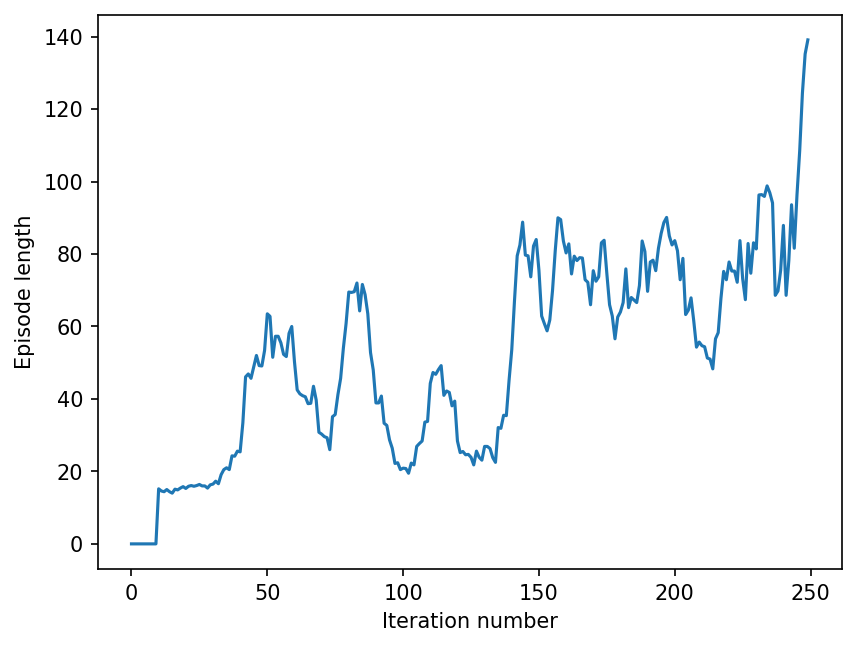

In [8]:
iters = np.arange(250)
plt.plot(iters, rolling_average(lengths, 10))
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]
agent_lengths = []

for i in tqdm(range(500)):
    
    env.reset()
    
    ep_length = 0
    
    done = False
    
    while not done:
        _, _, _, _, done = agent.take_step(env)
        ep_length += 1
    
    agent_lengths.append(ep_length)

 51%|██████████████████████████████████████████████▍                                            | 255/500 [09:45<10:32,  2.58s/it]

In [ ]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
random_lengths = []

for i in tqdm(range(500)):
    
    env.reset()
    
    done = False
    
    ep_length = 0
    
    while not done:
        action = np.random.randint(0, 2)
        _, _, done, _, _ = env.step(action)
        ep_length += 1
    
    random_lengths.append(ep_length)

In [ ]:
np.mean(agent_lengths)

In [ ]:
np.mean(random_lengths)

In [ ]:
plt.plot(np.arange(500), rolling_average(agent_lengths, 10), label='Agent')
plt.plot(np.arange(500), rolling_average(random_lengths, 10 ), label='Random')
plt.legend()

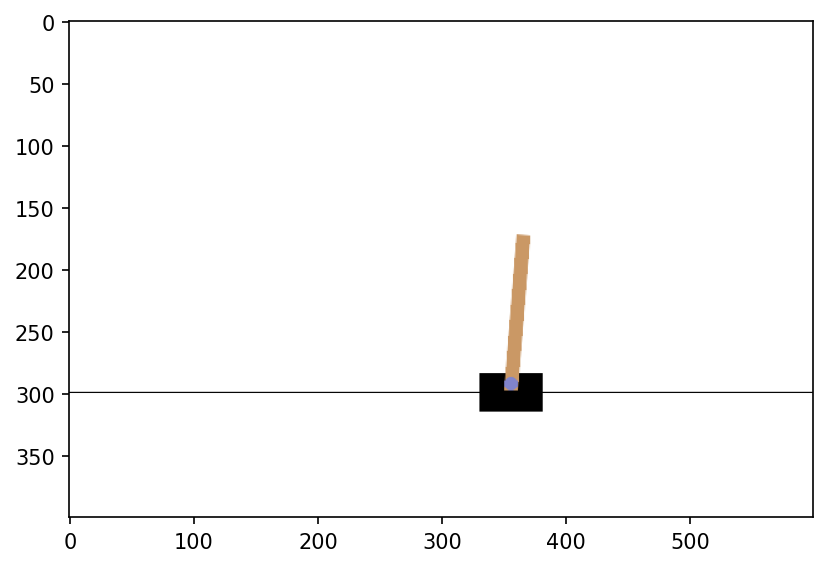

In [14]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
#     env.step(env.action_space.sample()) # take a random action
    env.step(agent.find_action(agent.state))
    agent.state = np.array(env.state)
    
env.close()